# **Acknowledgements**
To the following whose kernels I used extensively for this kernel:
* Manav Sehgal - "Titanic Data Science Solutions" - https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook
* Pedro Marcelino - "Comprehensive data exploration with Python" - https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
* Serigne - "Stacked Regressions to predict House Prices" - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
* Laurens ten Cate - "Top 2% of LeaderBoard - Advanced FE"    https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe

I highly recommend exploring these kernels to get a more indepth understanding of their respective approaches and also useful links.

# Me

I'm new to data science and this is my second challenge and Notebook.  So please excuse inefficient code as I learn:
* MathPlotLib abd Seaborn - I've spent ages learning about these libraries as I developed this Notebook
* Stats (e.g. testign assumptions) - learnt a lot about that developing this too - thanks to Pedro (see acknowledgements)
* Python


# **Workflow Stages**
***

**1. Question or problem definition**

    This competition challenges you to predict the final price of each home.
    
**2. Acquire training and testing data**

    Provided - 79 variables - excluding the 'Id' and predictor variable 'SalePrice'

**3. Data Analysis**

    3.1. Analyse by describing the data
   
        * Explore features (meta data)
        * Initial examination of the variables, segments, types and meaning

    3.2. Explore the target feature - SalePrice
   
        3.2.1. Univariate study - Focus on the target feature and try to know a little bit more about it.
    
        3.2.2. Bivariate study - Try to understand how the target feature relates to other features
       
            * Examine numerical features
            * Examine categorical features

        3.2.3. Multivariate study
   
           We'll use heatmaps and correlations to examine the interlationships between all the features

**4. Data Cleaning and Pre-Processing - prepare and cleanse data before modelling**

    4.1 Outliers
    4.2 Statistical transformations
    
**5. Feature Engineering**
   * Concatenation
   * NA's
   * Incorrect values
   * Factorization
   * Further Statistical transformation
   * Column removal
   * Creating features
   * Dummies
   * In-depth outlier detection
   * Overfit prevention
   * Baseline model
   
**6. Feature Selection**
   * Filter methods
       * baseline coefficients
   * Embedded methods
       * L2: Ridge Regression
       * L1: Lasso regression
           * In-depth coefficient analysis
       * Elasticnet
       * XGBoost
       * SVR
       * LightGBM

**7. Ensemble methods**
   * Stacked generalizations
   * Averaging
   * standard
   * weighted

**8. Prediction**

   * Supply or submit the results

    4.2. Drop features with large numbers of null values
    4.3. Drop features due to overlapping feature meaning
    4.4. Create / derive new features from existing
    4.5. Impute missing values by considering each feature one by one
    4.6. Transforming numerical features which are actually categorical
    4.7. Label encoding - some features may contain some information in their ordering set
    4.8. Log transformation of skewed values (consider / compare Box-Cox and Arcsine transformations)
    4.9. Get dummy features for categoprical features


**6. Feature Selection**


**6. Model, predict and solve the problem**

    6.1 Choose base models
    6.2 Cross validate the models
    6.3 Stack/Ensemble the models

**7. Visualize, report, and present the problem solving steps and final solution.**




In [458]:
# Data analysis and wranging
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import sys
import os
from decimal import *
import warnings

# Set ipython's max row, max columns and display width display settings
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 400)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

# machine learning
from scipy.stats import norm, skew
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# Feature selection
from sklearn.feature_selection import RFE

# Create the function to enable us to stop deprecated function warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

def feature_null_analysis(df_desc, df, drop_theshold): 
    # Create lists of information we want to see
    feat_names = list(df)
    feat_dtype = list(df.dtypes)
    feat_default = ['Mode: ' + df[feat].mode()[0] if df[feat].dtype == 'object' else 'Median: ' + str(round(df[feat].median(),2)) for feat in list(df)]
    feat_default_perc = ['%/total: ' + str(round(((train[feat].value_counts().iloc[0] / train.shape[0]) * 100),2))
                             if train[feat].dtype == 'object' else '' for feat in list(train)]
    feat_nulls = df.isnull().sum()
    feat_nullperc = df.isnull().mean() * 100
    feat_dropind = ['Y' if val >= drop_theshold else 'N' for val in feat_nullperc]
    
    # Combine the info into one soreted list
    feat_analysis_all = sorted(list(zip(feat_names,feat_dtype,feat_default,feat_default_perc,feat_nulls,feat_nullperc, feat_dropind))
                               ,key=lambda x: x[4], reverse=True)
    feat_analysis_nulls = [feat for feat in feat_analysis_all if feat[5] > 0]  # features with nulls
    feat_droplist = [feat[0] for feat in feat_analysis_all if feat[5] >= 15]  # features recommended to drop
    
    # print the results
    print_feature_null_analysis('features', feat_analysis_nulls)
    
    # Pass back the list of features recommended to drop to make it easier to drop them
    # return feat_analysis_nulls, feat_droplist

def print_feature_null_analysis(df_desc, feat_analysis):
    # print the analysis
    print('\n{: >{width}}'.format(df_desc, width=2 * PRINT_WIDTH))
    print('{: >{width}}'.format('+++++++++', width=2 * PRINT_WIDTH))
    print('{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}'.
          format('Feature','DType','Mode/Median','Perc. Rows = Mode','No. Nulls','Perc. Nulls','Drop? (Y/N)', width=PRINT_WIDTH))
    print('{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}'.
          format('=======','=====','===========','=================','=========','===========','=====', width=PRINT_WIDTH))
    
    for feat in feat_analysis:
        print('{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}.2F}{: <{width}}'.
              format(feat[0],str(feat[1]),feat[2],feat[3],feat[4],feat[5],feat[6], width=PRINT_WIDTH))

def drop_features(df_desc, df, feats_to_drop):
    print('\nBefore shape for {}: {}'.format(df_desc, df.shape))
    df.drop(feats_to_drop, axis=1, inplace=True)
    print('\nAfter shape for {}: {}'.format(df_desc, df.shape))
    feat_analysis_nulls, feat_droplist = feature_null_analysis(df_desc, df, NULL_PERC_DROP_PERC)  # As we've dropped one or more features we need to recreate the analysis
    return feat_analysis_nulls, FEATURES_DROPPED + feats_to_drop

# def drop_target_feature(df):
#     target_feature_data = df[TARGET_FEATURE]
#     df.drop(TARGET_FEATURE, axis=1, inplace=True)
#     return target_feature_data

# FEATURES_DROPPED = [] # Track the features we drop to make sure we don'y lose any as we wrangle ;-)
NULL_PERC_DROP_PERC = 15  # Set the threshold percentage of nulls in a column - will determine if it's recommended to drop
PRINT_WIDTH = 20  # Print parameter
# TARGET_FEATURE = ['SalePrice']
# ID_FEATURE = ['Id']

# 1. Question or problem definition

This competition challenges you to predict the final price of each home.

# 2. Acquire training and test data

In [400]:
# Check files in input directory - Windows
input_dir = 'C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices'
l = list(os.listdir(input_dir))
for f in l:
    print(f)
    
# Check files in input directory - Unix
# from subprocess import check_output
# print(check_output(["ls", 'C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices']).decode("utf8")) #check the files available in the directory

.git
.gitattributes
.gitignore
.ipynb_checkpoints
Ames, Iowa - House Price Prediction (ref-Copy1. Kaggle Challenge).ipynb
Ames, Iowa - House Price Prediction (ref. Kaggle Challenge).ipynb
Backup
data_description.txt
Feature Analysis.xlsx
Features Analysis.docx
submission - Decision Tree.csv
submission - Random Forests.csv
submission.csv
test.csv
train.csv


In [401]:
# Import Train and Test data
train = pd.read_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/train.csv')
test = pd.read_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [402]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [403]:
# Save then drop the Id column from Train and Test - not needed for modelling/prediction

# Save Id
train_id = train['Id']
test_id = train['Id']

# Print shapes before drop
print('\nBefore shape for {}: {}'.format('train', train.shape))
print('\nBefore shape for {}: {}'.format('test', test.shape))

# Drop Id
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Print shapes after drop
print('\nAfter shape for {}: {}'.format('train', train.shape))
print('\nAfter shape for {}: {}'.format('test', test.shape))


Before shape for train: (1460, 81)

Before shape for test: (1459, 80)

After shape for train: (1460, 80)

After shape for test: (1459, 79)


# 3. **Explore features - get to know the data**

## 3.1 Analyse by describing the data

**Create an Excel spreadhseet**
List the features and analyse them - indicating if you think they're gong to be influential; include the following:

* Variable - Variable name
* Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* Segment - Identification of the variables' segment. We can define three possible segments:
    * Building - a variable that relates to the physical characteristics of the building (e.g. 'OverallQual')
    * Space - a variable that reports space properties of the house (e.g. 'TotalBsmtSF')
    * Location - a variable that gives information about the place where the house is located (e.g. 'Neighborhood')
* Expectation - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible valuee
* Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'
* Comments - Any general comments that occured to us e.g. opportunity to derive a new feature (e.g. split or combine others)

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

* Nominal: 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition'


* Ordinal: 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'


* Interval - Discreet: 'YearBuilt', 'YearRemodAdd' (=same as YearBuilt if no remodelling), 'YrSold', 'MoSold', 'GarageYrBlt'

**Which features are numerical?**

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

* Nominal (Discreet): 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'


* Ratio - Continuous: 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'

**Which are the alphanumeric features?**

LotConfig, BldgType, HouseStyle are all alphanumeric features.


**Which features may contain errors or typos?**
This is hard for such a large dataset with so many features - but there don't appear to be any obvious features which could contain typos such as a Name or a Title feature.

Creating the XLS will help become more familiar with the data and it's meaning - which is half the battle.

## 3.2 Identify features with excessive null values

The process of dealing with nulls is heavily dependant on the meaning of the data and it's relevance to the model. However, if there are greater than ~15% (parameterised in the routine below) of a feature's values which are nulls I drop the feature.

* feature_null_analysis - creates a list which details relevant information to help identify features to drop if they have a high null count. It also details the mode or median value for those columns
* print_feature_null_analysis - prints the analysis
* drop_features - drops those features passed into it and maintains a list of features dropped across repeated executions of his proc

In [404]:
# Analyse and print the features for Null values
feature_null_analysis('train', train, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
PoolQC              object              Mode: Gd            %/total: 0.21       1453                99.52               Y                   
MiscFeature         object              Mode: Shed          %/total: 3.36       1406                96.30               Y                   
Alley               object              Mode: Grvl          %/total: 3.42       1369                93.77               Y                   
Fence               object              Mode: MnPrv         %/total: 10.75      1179                80.75               Y                   
FireplaceQu         object              Mode: Gd            %/total: 26

## 3.3. Explore the independent variable - SalePrice


### 3.3.1 Univariate Analysis

In [405]:
train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64



No warnings signs here - min above zero - be interesting to see if we have outliers which could impact our analysis and model accuracy.



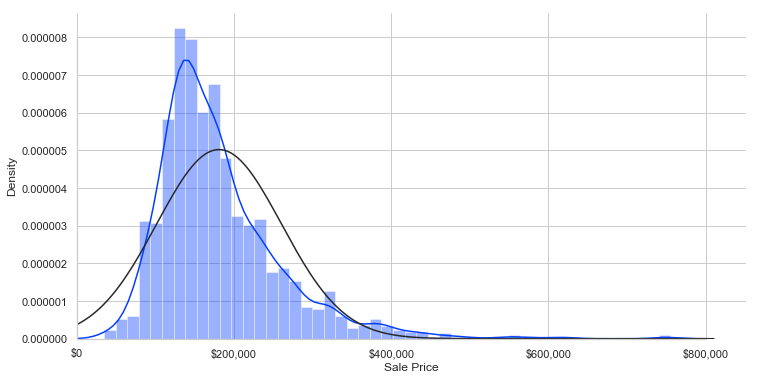

In [406]:
sns.set(style="whitegrid", palette='bright')
fig, ax = plt.subplots(figsize=(12,6))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.0F}'.format(x))) 
    p = sns.distplot(train['SalePrice'] , fit=stats.norm, ax=ax)
    ax.set(xlabel='Sale Price', ylabel='Density')
    sns.despine(trim=True)
    p.set(xlim=(0, None), ylim=(0,None))

Positively skewed with a few significant outliers at around $500-800k.

In [457]:
# Get the fitted parameters used by the function plus skewness and kurtosis
mu, sigma = stats.norm.fit(train['SalePrice'])
sales_skew = train['SalePrice'].skew()
sales_kurtosis = train['SalePrice'].kurtosis()
print( '\n mu(Avg) = {:.2f}, sigma(SD) = {:.2f}, skew = {:.2F} and kurtosis = {:.2F}\n'.format(mu, sigma, sales_skew, sales_kurtosis))


 mu(Avg) = 12.02, sigma(SD) = 0.40, skew = 0.12 and kurtosis = 0.80



##  3.3.2 Bivariate analysis

**Relationship with selected numerical variables**

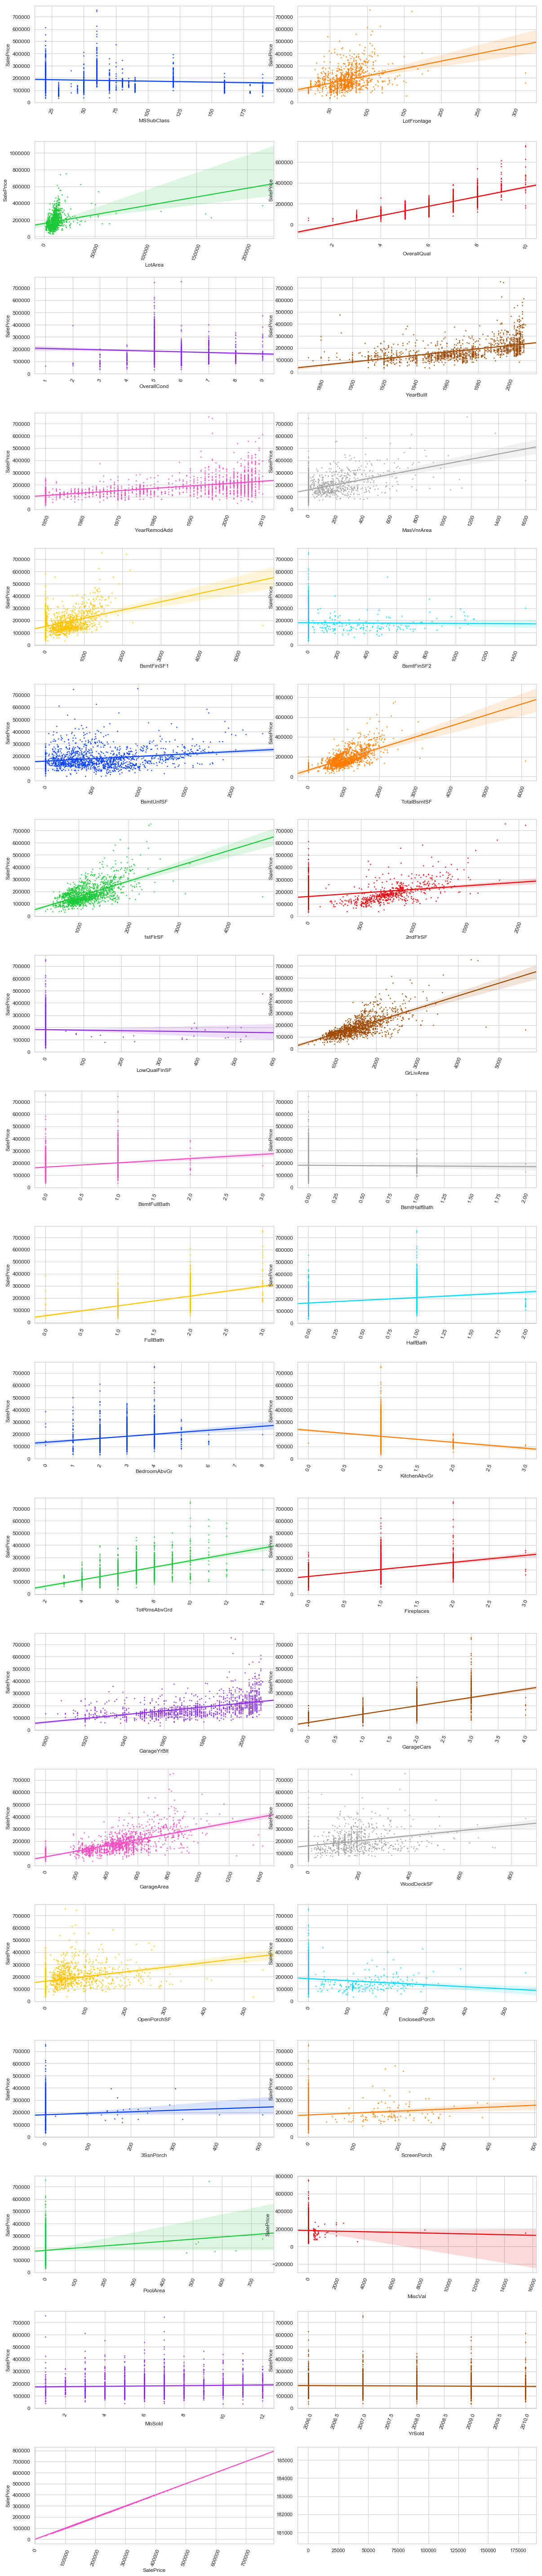

In [408]:
numeric_features = train.select_dtypes(exclude=['object']).columns.tolist()

grid_cols = 2
pair_plots = 1
grid_rows = math.ceil(len(numeric_features) / ((grid_cols // pair_plots)))
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20,80))

axes = axes.ravel()
colix = 0
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(len(numeric_features)):
        ax = axes[i]
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(12)
        ax.set_ylabel('SalePrice', fontsize=12)    
        ax.set_xlabel(numeric_features[colix], fontsize=12)
        ax.tick_params(axis='x', rotation=70)
        
        g = sns.regplot(x=numeric_features[colix], y='SalePrice', ax=ax, data=train, scatter_kws={'s':3})
        colix += 1

Looking at the regression plots above there are a few positive linear reltionships of varying stregnths:
* TotalBsmtSF
* 1stFlrFSF
* GrLivArea
* Garage Area

**Relationship with selected categorical "Space" segment variables**

* Ignore features with a > 15% number of nulls ( PoolQC, MiscFeature, Alley, Fence, FirePlaceQu)

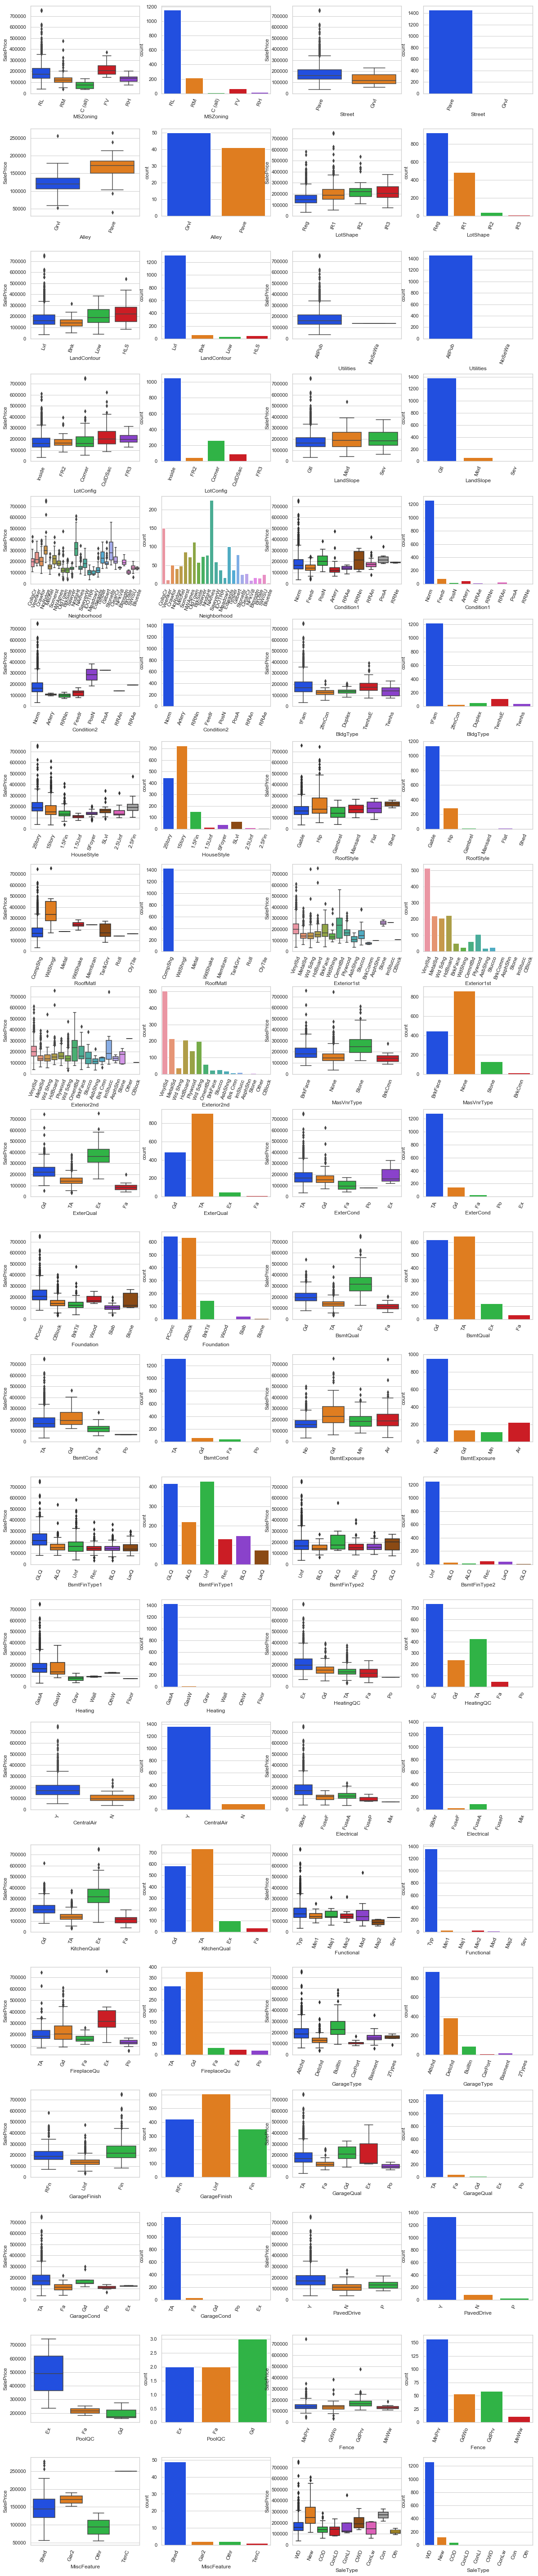

In [409]:
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

feat_cols = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 
           'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

grid_cols = 4
pair_plots = 2
grid_rows = len(categorical_features) // ((grid_cols // pair_plots))
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20,80))
axes = axes.ravel()
dv = 'SalePrice'
colix = 0
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(0,grid_rows * grid_cols,2):
        g = sns.boxplot(x=categorical_features[colix], y=dv, data=train, ax=axes[i])
        p = sns.countplot(x=categorical_features[colix], data=train, ax=axes[i+1])
        g.set_xticklabels(g.get_xticklabels(), rotation=70, fontsize = 12)
        p.set_xticklabels(g.get_xticklabels(), rotation=70, fontsize = 12)
        if categorical_features[colix] in ['YearBuilt', 'YearRemodAdd']:
            g.set_xticklabels(g.get_xticklabels(), visible=False)
            p.set_xticklabels(p.get_xticklabels(), visible=False)
        colix += 1

**Observations:**

Most category distributions are heavily skewed to a single or a few values and should be considered for removal

* QverallQual - show a clear exponential distribution
* YearBuilt and YearRemodelled - show a recent increase in sales price bur the count plot indicates a surge in recent years of both units sold and remodelled
* MoSold - it's clear the most popular time for selling is in the summer (May through July) -  July sales seem to attain higher sales prices

**Decisions:**

Keep columns:
* OverallQual
* MoSold

Other columns can be included for now - but test the impact on accuracy if they are selectively removed.

## 3.4. Multivariate Analysis

### 3.4.1 Produce a Heatmap to examine the relative coefficicients between features


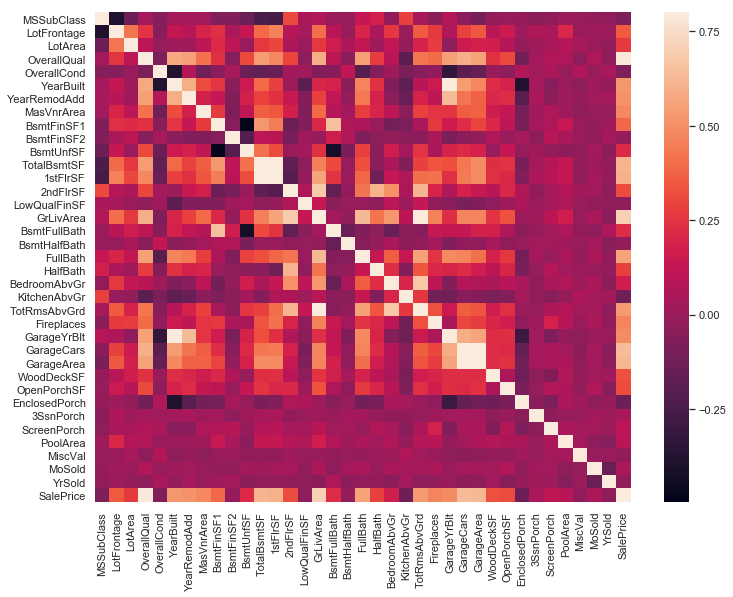

In [410]:
corrmat = train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=False);

**Observations:**

OverallQual and GrLivArea are strongly correlated with SalePrice.  GarageCars (and GarageArea) too.

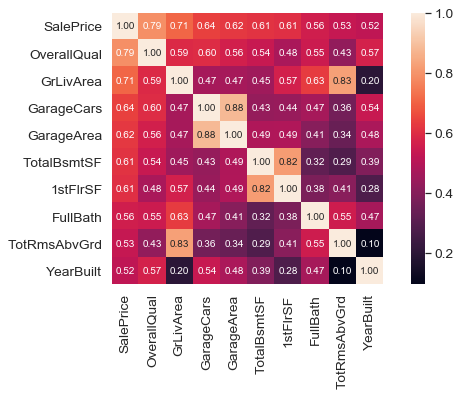

In [411]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 5))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Observations:**
   * GarageCars and GarageArea are strongly correlated - not a huge surprise as the number of cars you can fit in a garage is dependent on the size of the garage
   * TotalBsmtSF is strongly correlated to 1stFlrSF - again undertandable unless you have either a massive basement or a exceptionally large 1st floor
  
**Decisons:**
   * We can drop GarageArea - as it's covered by GarageCars
   * We cab drop 1stFlrSF - as it's covered by TotalBsmtSF

### 3.4.2 Scatter plots between the target feature (SalePrice) and selected independent features

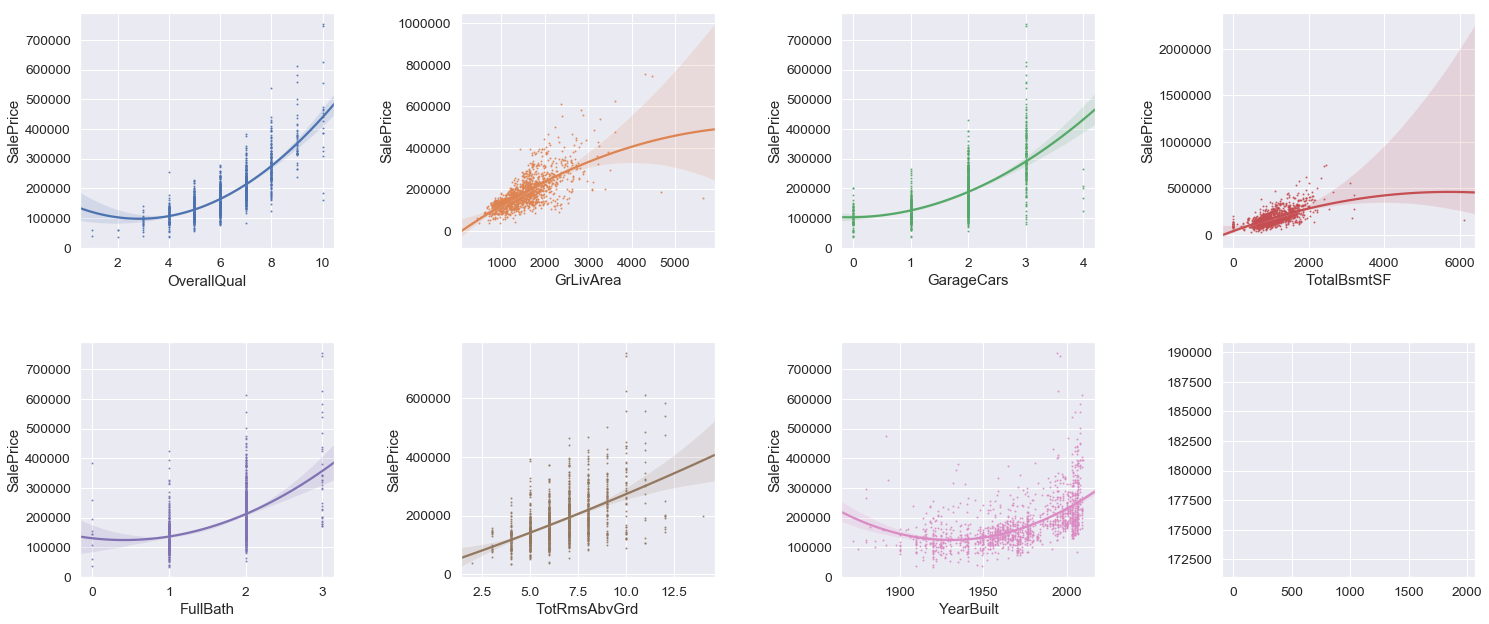

In [412]:
iv_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd','YearBuilt']
dv = train['SalePrice']
grid_cols = 4
pair_plots = 1
colix = 0
grid_rows = math.ceil(len(iv_cols) / ((grid_cols // pair_plots)))
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(25,8))
axes = axes.ravel()
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.5)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(len(iv_cols)):
        g = sns.regplot(x=iv_cols[colix], y=dv, ax=axes[i], data=train, scatter_kws={'s':1}, order=2)
        colix += 1

**Observations:**
   * TotalRmsAbvGrd and GrLivArea - appears to be a straight line indicating, unsurprisingly, there is a strong relationship between the number of rooms and the space available
   * YearBuilt and OverallQual - also show some degree of exponentiality especially at the top, most recent years.  It could indicate the maxing out of prices in the area - folks just won't pay more than a certain threshold for those neighborhoods
   * TotalBsmtSF is strongly correlated to 1stFlrSF - again, asindicated in the heatmap above, undertandable unless you have either a massive basement or a exceptionally large 1st floor

Some features have a very similar corrleation and overlap:
* TotalBsmtSF and 1stFlrSF have exactly the same correlation and are very likely to be aligend because the basement size will likely dictate the size of the 1st floor
* The key Garage variable is GarageCars, so we'll get rid of the others
* We'll treat all the Basement features in a similar way to the Garage features for the same reason (keeping TotalBsmtSF)

**Decisions:**
* Drop all Garage festures except GarageCars
* Drop all Basement features except TotalBsmtSF
* Drop 1stFlrSF as it's covered by TotalBsmtSF


# 4. 4. Data Cleaning and Pre-Processing (Prepare and cleanse data before modelling)

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals as part of this and feature engineering activities.

## 4.1 Outliers 

### 4.1.1 Outliers - Univariate analysis

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [413]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


**Observations:**

Lower range close to zero
Upper range indicates a couple of large outliers (the 7+ values)

**Decisions:**

Leave alone for now

### 4.1.2 Outliers - Bivariate analysis

#### 4.1.2.1 GrLivArea

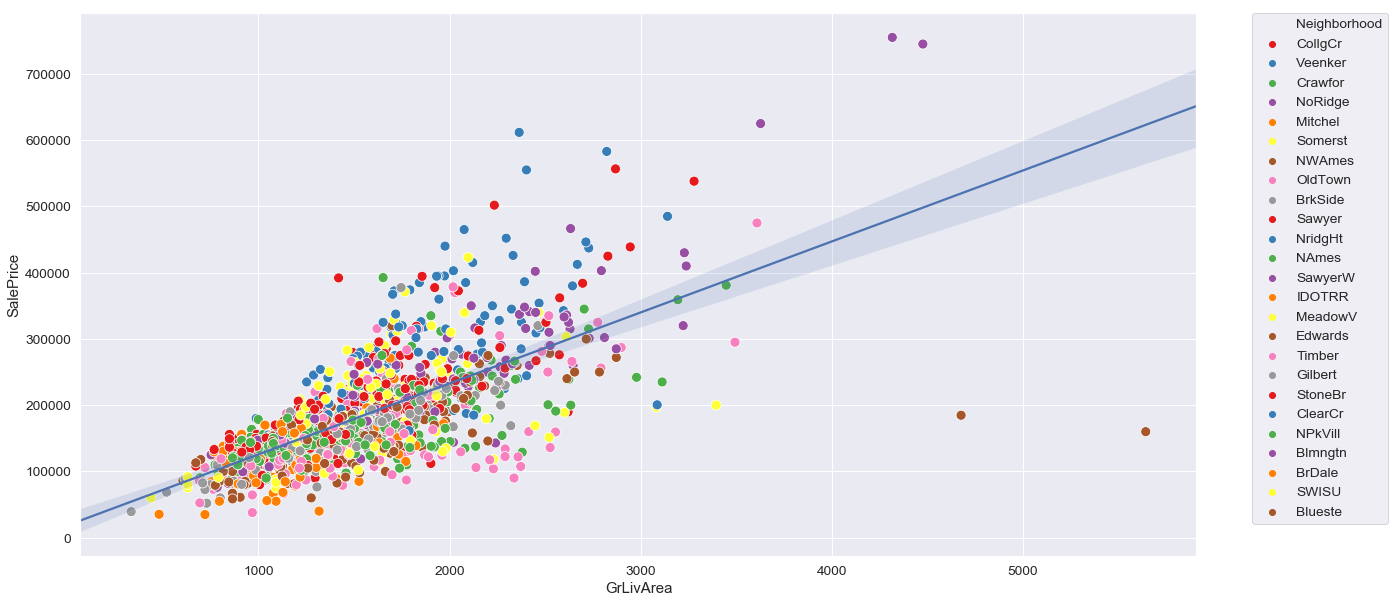

In [414]:
fig, ax = plt.subplots(figsize=(20,10))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    g = sns.scatterplot(train['GrLivArea'], train['SalePrice'], palette="Set1", hue=train['Neighborhood'], legend='full', s=100)
    sns.regplot(train['GrLivArea'], train['SalePrice'], data=train, scatter=False)  # Add a regression line to the scatterplot
    # Put the legend out of the figure
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Investigate the outliers**

**Obervations:**
* We see the two outliers at the top, with SalePrices of over 700,000
* We also see two outliers with a large GrLivArea, over 4000 sq ft.  Odd given their respective SalePrice which you'd expect to be higher
* They all have above average number of rooms (TotRmsAbvGrd)

**Decisions:**
* The higher priced houses seem to followign the trend, so we'll leave them alone
* The lower priced houses with higher GrLivArea's seem like anomalies. Both are neighborhoods locates in Ames, near the university (https://www.zillow.com/ames-ia/) - so from the data and this brief analysis of the location I can't see why their prices would be so low.  So, let's investigate the outliers to double check on their details and if no surprises delete them.


In [415]:
outliers_df = train.query('GrLivArea > 4500 | SalePrice > 700000').sort_values('SalePrice')
outliers_df.sort_values('SalePrice', ascending=False)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,60,RL,104.000,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.000,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,60,RL,160.000,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.000,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.000,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
523,60,RL,130.000,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.000,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.000,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.000,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [416]:
# Deleting Outliers
print('\nBefore shape for {}: {}'.format('train', train.shape))
train = train.drop(train[(train['GrLivArea'] > 4500) & (train['SalePrice'] < 200000)].index)


Before shape for train: (1460, 80)


In [417]:
# Check deletion
print('\nAfter shape for {}: {}'.format('train', train.shape))
train.sort_values(by = 'GrLivArea', ascending = False)[:2]


After shape for train: (1458, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,60,RL,160.000,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.000,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.000,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
691,60,RL,104.000,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.000,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


#### 4.1.2.2 TotalBsmtSF

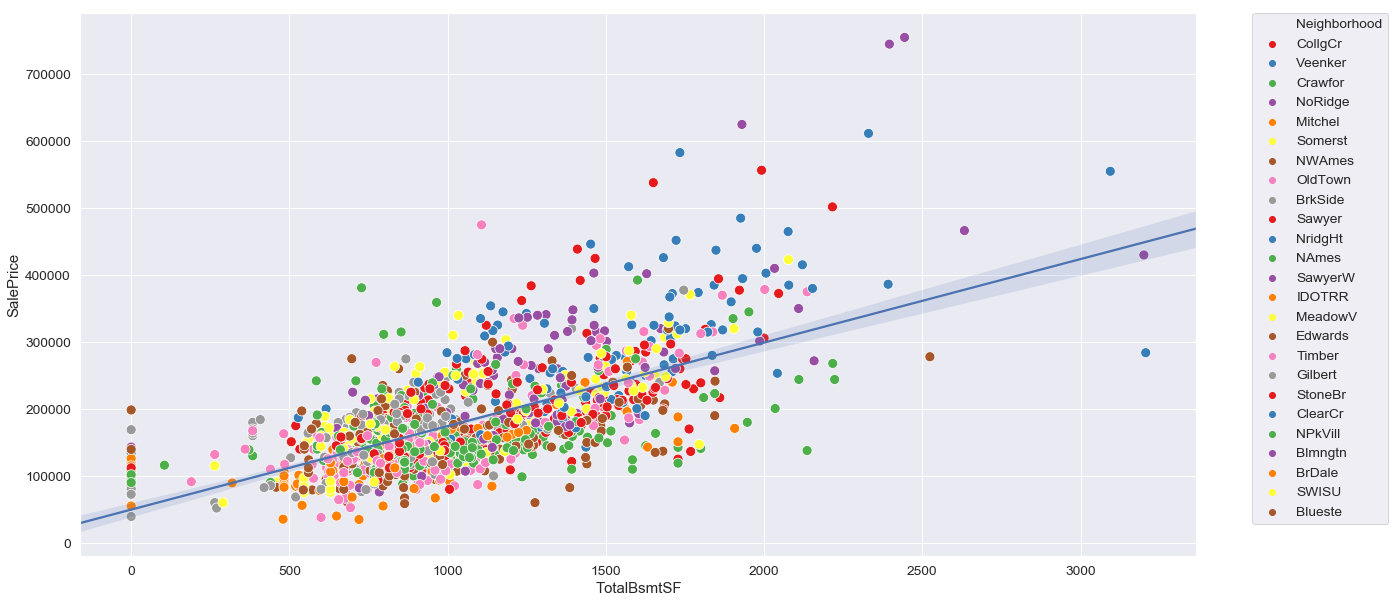

In [418]:
fig, ax = plt.subplots(figsize=(20,10))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    g = sns.scatterplot(train['TotalBsmtSF'], train['SalePrice'], palette="Set1", hue=train['Neighborhood'], legend='full', s=100)
    sns.regplot(train['TotalBsmtSF'], train['SalePrice'], data=train, scatter=False)  # Add a regression line to the scatterplot
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Investigate the outliers**

**Observations:**
* Fairly even number of observations either sie of the regression line
* Some strange occurences with TotalBsmtSF > 3000 - but they look broadly on trend

**Decisions:**
* Do nothing

## 4.2 Target Variable

### 4.2.1 Analysis

More analysis on SalePrice.

Let's remind ourselves of the distribution.

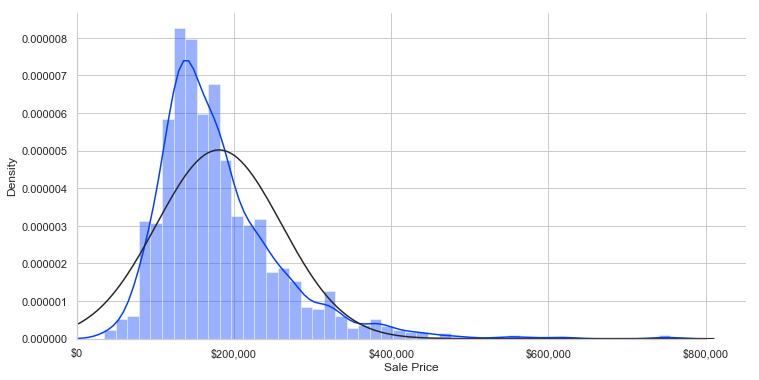

In [419]:
sns.set(style="whitegrid", palette='bright')
fig, ax = plt.subplots(figsize=(12,6))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.0F}'.format(x))) 
    p = sns.distplot(train['SalePrice'] , fit=stats.norm, ax=ax)
    ax.set(xlabel='Sale Price', ylabel='Density')
    sns.despine(trim=True)
    p.set(xlim=(0, None), ylim=(0,None))

Now lets get the QQ-plot.

The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution 
such as a Normal or exponential. For example, if we run a statistical analysis that assumes our dependent variable is Normally distributed, 
we can use a Normal Q-Q plot to check that assumption. It’s just a visual check, not an air-tight proof, so it is somewhat subjective.
But it allows us to see at-a-glance if our assumption is plausible, and if not, how the assumption is violated and what data points contribute 
to the violation.
A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, 
we should see the points forming a line that’s roughly straight. Here’s an example of a Normal Q-Q plot when both sets of quantiles truly come
from Normal distributions.

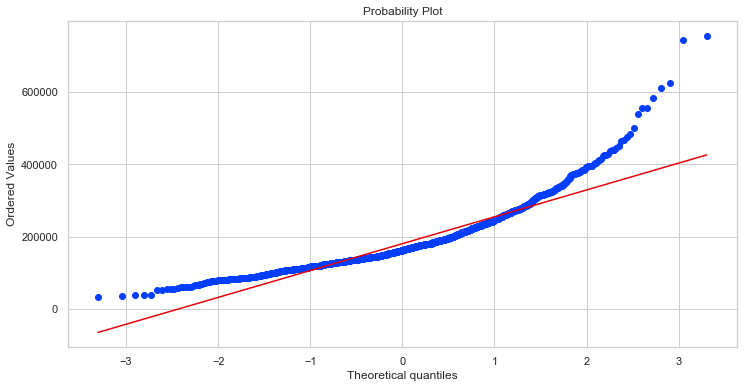

In [420]:
# Get the QQ-plot
fig = plt.figure(figsize=(12,6))
res = stats.probplot(train['SalePrice'], plot=plt)
# sns.despine(trim=True)
plt.show()

### 4.2.2 Log transformation of skewed values

If SalePrice were a normal distribution then we'd see a straight line.  We already know it's right skewed and this visual is a good way to examine it and also compare it.  For our model we want to make it more normal 


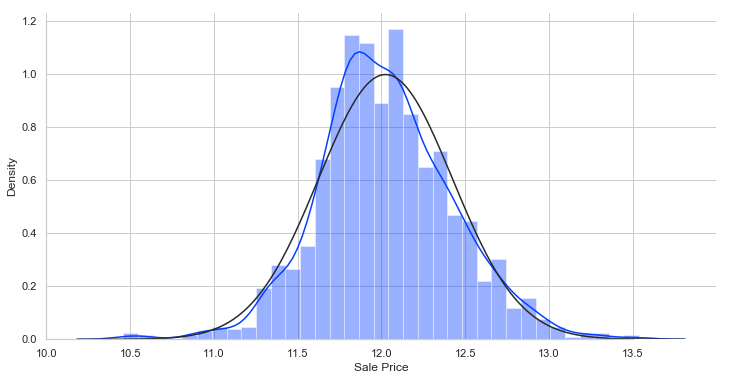

In [421]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
fig, ax = plt.subplots(figsize=(12,6))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    # ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.0F}'.format(x))) 
    p = sns.distplot(train['SalePrice'] , fit=stats.norm, ax=ax)
    ax.set(xlabel='Sale Price', ylabel='Density')
    sns.despine(trim=True)
    # p.set(xlim=(0, None), ylim=(0,None))

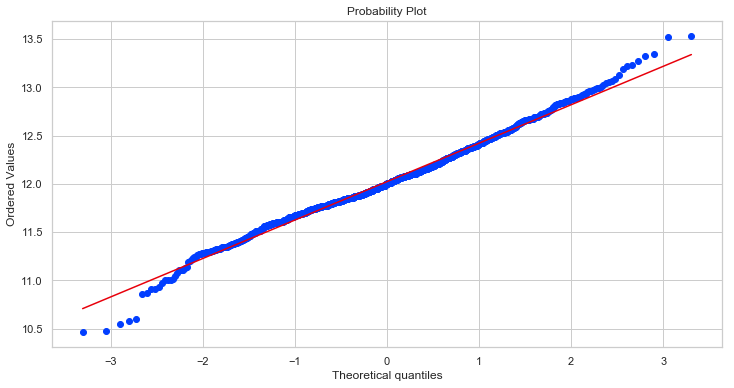

In [422]:
# Get the QQ-plot
fig = plt.figure(figsize=(12,6))
res = stats.probplot(train['SalePrice'], plot=plt)
# sns.despine(trim=True)
plt.show()

# 5. Feature Engineering

   * 5.1 Concatenation
   * 5.2 NA's
   * 5.3 Incorrect values
   * 5.4 Factorization
   * 5.5 Further Statistical transformation
   * 5.6 Column removal
   * 5.7 Creating features
   * 5.8 Dummies
   * 5.9 In-depth outlier detection
   * 5.10 Overfit prevention
   * 5.11 Baseline model

## 5.1 Concatenation

Save the target variable then drop it from the train datset. Set up the train and test feature df's then concatenate them so we can apply changes to features across both in one statement.

In [423]:
y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
print('train_features shape: ', train_features.shape)
print('train_features shape: ', test_features.shape)

train_features shape:  (1458, 79)
train_features shape:  (1459, 79)


In [424]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print('features shape: ', features.shape)

features shape:  (2917, 79)


## 5.2 NA's

      * How prevalent is missing data?
      * Is there a pattern?

We need to consider remedial actions to deal with missing values which may include dropping columns or rows.

Examine NA's by cateogory and impute them as best we can

In [425]:
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
PoolQC              object              Mode: Ex            %/total: 0.14       2908                99.69               Y                   
MiscFeature         object              Mode: Shed          %/total: 3.36       2812                96.40               Y                   
Alley               object              Mode: Grvl          %/total: 3.43       2719                93.21               Y                   
Fence               object              Mode: MnPrv         %/total: 10.77      2346                80.43               Y                   
FireplaceQu         object              Mode: Gd            %/total: 25

* Functional: The documentation (https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) says that we should assume "Typ", so lets impute that - it's the most common value
* Electrical: The documentation doesn't give any information but obviously every house has this so let's impute the most common value: "SBrkr" - it't the most common value
* KitchenQual: Similar to Electrical, most common value: "TA"
* Exterior 1 and Exterior 2: Let's use the most common one here
* SaleType: Similar to electrical, let's use most common value

In [426]:
features['Functional'] = features['Functional'].fillna(features['Functional'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

**PoolQC**

Check out observations where the property has a Pool but PoolQC is set to NA

In [427]:
features.query('PoolArea > 0 & PoolQC.isnull()', engine='python')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2418,20,RL,75.000,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,BLQ,595.000,Rec,354.000,156.000,1105.000,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.000,0.000,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.000,Fin,1.000,280.000,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
2501,50,RL,104.000,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,CBlock,TA,TA,No,Unf,0.000,Unf,0.000,1105.000,1105.000,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.000,0.000,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.000,Unf,2.000,515.000,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
2597,20,RL,200.000,43500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,3,5,1953,1953,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,GasA,Ex,Y,SBrkr,2034,0,0,2034,0.000,0.000,1,0,2,1,TA,9,Min1,0,NaN,2Types,1953.000,RFn,4.000,1041.000,TA,TA,N,483,266,0,0,0,561,NaN,GdPrv,NaN,0,6,2007,WD,Normal


From the data description we can impute the PoolQC from the OverallCond of the house:

OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
2418 - 4 - Below Average
2501 - 6 - Above Average	
2597 - 3 - Fair
       
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

So we set PoolQC as follows:
2418 - Fa
2501 - Gd
2597 - Fa 


In [428]:
features.loc[2418, 'PoolQC'] = 'Fa'
features.loc[2501, 'PoolQC'] = 'Gd'
features.loc[2597, 'PoolQC'] = 'Fa'

**Garage Features**

Let's check for houses with detached garages with all/some null garage features

In [429]:
features.query('GarageType == "Detchd" & GarageYrBlt.isnull()', engine='python')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.000,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,PConc,TA,TA,Mn,Rec,196.000,Unf,0.000,1046.000,1242.000,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.000,0.000,2,0,5,1,TA,8,Typ,0,NaN,Detchd,nan,NaN,1.000,360.000,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.000,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.000,TA,TA,BrkTil,Gd,TA,No,ALQ,548.000,Unf,0.000,311.000,859.000,GasA,Ex,Y,SBrkr,942,886,0,1828,0.000,0.000,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,nan,NaN,nan,nan,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


So there are houses with garages that are detached but that have NaN's for all other Garage variables. Let's impute these manually too.

In [430]:
features.loc[2124, 'GarageYrBlt'] = features.loc[2124, 'YearRemodAdd']
features.loc[2574, 'GarageYrBlt'] = features.loc[2574, 'YearRemodAdd']

features.loc[2124, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageFinish'] = features['GarageFinish'].mode()[0]

features.loc[2574, 'GarageCars'] = features['GarageCars'].median()

features.loc[2124, 'GarageArea'] = features['GarageArea'].median()
features.loc[2574, 'GarageArea'] = features['GarageArea'].median()

features.loc[2124, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2574, 'GarageQual'] = features['GarageQual'].mode()[0]

features.loc[2124, 'GarageCond'] = features['GarageCond'].mode()[0]
features.loc[2574, 'GarageCond'] = features['GarageCond'].mode()[0]

**Basement Features**

* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* BsmtFinSF1
* BsmtFinSF2
* BsmtUnfSF
* TotalBsmtSF

In [431]:
# Create a new df focusing on where any basement figure are null
basement_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
basement_df = features[basement_features]
basement_df_nulls = basement_df[basement_df.isnull().any(axis=1)]

In [432]:
#now select just the rows that have less then 5 NA's, meaning there is incongruency in the row
basement_df_nulls[(basement_df_nulls.isnull()).sum(axis=1) < 5]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,NaN,1124.000,479.000,1603.000,3206.000
947,Gd,TA,NaN,Unf,Unf,0.000,0.000,936.000,936.000
1485,Gd,TA,NaN,Unf,Unf,0.000,0.000,1595.000,1595.000
2038,Gd,NaN,Mn,GLQ,Rec,1044.000,382.000,0.000,1426.000
2183,TA,NaN,No,BLQ,Unf,1033.000,0.000,94.000,1127.000
2215,NaN,Fa,No,Unf,Unf,0.000,0.000,173.000,173.000
2216,NaN,TA,No,Unf,Unf,0.000,0.000,356.000,356.000
2346,Gd,TA,NaN,Unf,Unf,0.000,0.000,725.000,725.000
2522,TA,NaN,Av,ALQ,Unf,755.000,0.000,240.000,995.000


In [433]:
features.loc[332, 'BsmtFinType2'] = 'ALQ' #since SF2 smaller than SF1
features.loc[947, 'BsmtExposure'] = 'No' 
features.loc[1485, 'BsmtExposure'] = 'No'
features.loc[2038, 'BsmtCond'] = 'TA'
features.loc[2183, 'BsmtCond'] = 'TA'
features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
PoolQC              object              Mode: Ex            %/total: 0.14       2905                99.59               Y                   
MiscFeature         object              Mode: Shed          %/total: 3.36       2812                96.40               Y                   
Alley               object              Mode: Grvl          %/total: 3.43       2719                93.21               Y                   
Fence               object              Mode: MnPrv         %/total: 10.77      2346                80.43               Y                   
FireplaceQu         object              Mode: Gd            %/total: 25

**MSZoning**

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
       
Let's find the mode for each MSSubClass (type of dwelling) and set NA values to the mode.

In [434]:
features.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.mode()[0])

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [435]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
PoolQC              object              Mode: Ex            %/total: 0.14       2905                99.59               Y                   
MiscFeature         object              Mode: Shed          %/total: 3.36       2812                96.40               Y                   
Alley               object              Mode: Grvl          %/total: 3.43       2719                93.21               Y                   
Fence               object              Mode: MnPrv         %/total: 10.77      2346                80.43               Y                   
FireplaceQu         object              Mode: Gd            %/total: 25

**MasVnrType & MasVnrArea**

MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

There are a similar number of NA's - let check that they are the same observations and also look at the one observation which isn't.

In [436]:
features.loc[features['MasVnrType'].isnull() & features['MasVnrArea'].notnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2608,20,RL,124.000,27697,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,NaN,198.000,TA,TA,CBlock,TA,TA,No,BLQ,811.000,Unf,0.000,585.000,1396.000,GasA,TA,N,SBrkr,1608,0,0,1608,0.000,0.000,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1961.000,Unf,1.000,444.000,TA,Fa,Y,152,38,0,0,0,0,NaN,NaN,NaN,0,11,2007,COD,Abnorml


 The most common MasVnrType in the neighborhood 'Mitchel' is None. So, we'll set it to the most common overall, 'BrkFace;

In [437]:
features.groupby('Neighborhood')['MasVnrType'].apply(lambda x: x.mode()[0])

Neighborhood
Blmngtn    BrkFace
Blueste       None
BrDale     BrkFace
BrkSide       None
ClearCr       None
CollgCr       None
Crawfor       None
Edwards       None
Gilbert       None
IDOTRR        None
MeadowV       None
Mitchel       None
NAmes         None
NPkVill       None
NWAmes     BrkFace
NoRidge    BrkFace
NridgHt      Stone
OldTown       None
SWISU         None
Sawyer        None
SawyerW       None
Somerst       None
StoneBr       None
Timber     BrkFace
Veenker       None
Name: MasVnrType, dtype: object

In [438]:
features.loc[2608, 'MasVnrType'] = 'BrkFace'
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
PoolQC              object              Mode: Ex            %/total: 0.14       2905                99.59               Y                   
MiscFeature         object              Mode: Shed          %/total: 3.36       2812                96.40               Y                   
Alley               object              Mode: Grvl          %/total: 3.43       2719                93.21               Y                   
Fence               object              Mode: MnPrv         %/total: 10.77      2346                80.43               Y                   
FireplaceQu         object              Mode: Gd            %/total: 25

For the remainder of the categorical variables we'll set the values to 'None'

In [439]:
categorical_features = list(features.select_dtypes(include='object'))
features.update(features[categorical_features].fillna('None'))
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
LotFrontage         float64             Median: 68.0                            486                 16.66               Y                   
GarageYrBlt         float64             Median: 1979.0                          157                 5.38                N                   
MasVnrArea          float64             Median: 0.0                             23                  0.79                N                   
BsmtFullBath        float64             Median: 0.0                             2                   0.07                N                   
BsmtHalfBath        float64             Median: 0.0                    

**LotFrontage**

Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [440]:
features.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.median())

Neighborhood
Blmngtn   43.000
Blueste   24.000
BrDale    21.000
BrkSide   51.000
ClearCr   80.500
CollgCr   70.000
Crawfor   70.000
Edwards   64.500
Gilbert   64.000
IDOTRR    60.000
MeadowV   21.000
Mitchel   74.000
NAmes     73.000
NPkVill   24.000
NWAmes    80.000
NoRidge   89.000
NridgHt   92.000
OldTown   60.000
SWISU     60.000
Sawyer    72.000
SawyerW   67.000
Somerst   72.500
StoneBr   60.000
Timber    82.000
Veenker   80.000
Name: LotFrontage, dtype: float64

In [441]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.median())
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
GarageYrBlt         float64             Median: 1979.0                          157                 5.38                N                   
MasVnrArea          float64             Median: 0.0                             23                  0.79                N                   
BsmtFullBath        float64             Median: 0.0                             2                   0.07                N                   
BsmtHalfBath        float64             Median: 0.0                             2                   0.07                N                   
BsmtFinSF1          float64             Median: 368.0                  

**GarageYrBlt**


In [442]:
garage_features = ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
features.loc[features['GarageYrBlt'].isnull(), list(garage_features)]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,None,nan,None,0.000,0.000,None,None
48,None,nan,None,0.000,0.000,None,None
78,None,nan,None,0.000,0.000,None,None
88,None,nan,None,0.000,0.000,None,None
89,None,nan,None,0.000,0.000,None,None
99,None,nan,None,0.000,0.000,None,None
108,None,nan,None,0.000,0.000,None,None
125,None,nan,None,0.000,0.000,None,None
127,None,nan,None,0.000,0.000,None,None
140,None,nan,None,0.000,0.000,None,None


In [443]:
# Check for any anomalies
features.loc[features['GarageYrBlt'].isnull() & features['GarageArea'] > 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


**MasVnrArea**


In [444]:
features[(features['MasVnrArea'].isnull())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
234,60,RL,64.000,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,nan,Gd,TA,PConc,Gd,TA,No,GLQ,625.000,Unf,0.000,235.000,860.000,GasA,Ex,Y,SBrkr,860,1100,0,1960,1.000,0.000,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.000,Fin,2.000,440.000,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal
528,20,RL,70.000,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,nan,Gd,TA,PConc,TA,TA,No,Rec,1219.000,Unf,0.000,816.000,2035.000,GasA,TA,Y,SBrkr,2515,0,0,2515,1.000,0.000,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.000,RFn,2.000,484.000,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca
649,60,FV,72.500,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,nan,Gd,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,813.000,813.000,GasA,Ex,Y,SBrkr,822,843,0,1665,0.000,0.000,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.000,RFn,2.000,562.000,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
935,20,RL,67.000,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,nan,Gd,TA,PConc,Gd,TA,No,GLQ,833.000,Unf,0.000,343.000,1176.000,GasA,Ex,Y,SBrkr,1200,0,0,1200,1.000,0.000,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.000,RFn,2.000,555.000,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal
972,20,FV,72.500,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,nan,Gd,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,1428.000,1428.000,GasA,Ex,Y,SBrkr,1428,0,0,1428,0.000,0.000,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.000,Fin,2.000,480.000,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial
976,120,FV,72.500,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,nan,Gd,TA,PConc,Gd,TA,No,GLQ,1106.000,Unf,0.000,135.000,1241.000,GasA,Ex,Y,SBrkr,1241,0,0,1241,1.000,0.000,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.000,Fin,2.000,569.000,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial
1242,20,RL,92.000,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,nan,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.000,Unf,0.000,690.000,2076.000,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.000,0.000,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.000,Fin,3.000,850.000,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial
1277,60,RL,70.000,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,nan,Gd,TA,PConc,Gd,TA,No,GLQ,804.000,Unf,0.000,324.000,1128.000,GasA,Ex,Y,SBrkr,1128,903,0,2031,1.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.000,RFn,2.000,577.000,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal
1689,60,RL,64.000,12891,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,nan,Gd,TA,PConc,Ex,TA,No,GLQ,651.000,Unf,0.000,219.000,870.000,GasA,Ex,Y,SBrkr,878,1126,0,2004,1.000,0.000,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002.000,Fin,

No anomalies,so we can impute the value 0 assuming that the properties do not have this feature.

In [445]:
numeric_features = list(features.select_dtypes(exclude='object'))
features.update(features[numeric_features].fillna(0))
# Analyse and print the features for Null values
feature_null_analysis('features', features, NULL_PERC_DROP_PERC)


                                features
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               


## 5.3 Incorrect Values

Examine min/max values to check validiy of data.


In [446]:
features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000
mean,57.136,68.656,10139.439,6.086,5.565,1971.288,1984.248,100.931,438.865,49.599,560.504,1048.968,1157.692,335.862,4.698,1498.252,0.429,0.061,1.567,0.380,2.860,1.045,6.448,0.596,1871.635,1.766,472.453,93.629,47.280,23.114,2.604,16.073,2.089,50.861,6.214,2007.793
std,42.532,12.897,7807.037,1.407,1.113,30.287,20.892,178.032,444.181,169.232,439.699,429.472,385.264,428.120,46.413,496.909,0.524,0.246,0.552,0.503,0.823,0.215,1.564,0.645,447.161,0.761,214.574,126.533,67.119,64.263,25.197,56.202,34.561,567.595,2.713,1.315
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000
25%,20.000,64.000,7476.000,5.000,5.000,1953.000,1965.000,0.000,0.000,0.000,220.000,793.000,876.000,0.000,0.000,1126.000,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1957.000,1.000,320.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2007.000
50%,50.000,70.000,9452.000,6.000,5.000,1973.000,1993.000,0.000,368.000,0.000,467.000,988.000,1082.000,0.000,0.000,1444.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1977.000,2.000,480.000,0.000,26.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000
75%,70.000,73.000,11556.000,7.000,6.000,2001.000,2004.000,163.000,733.000,0.000,804.000,1302.000,1384.000,704.000,0.000,1743.000,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2001.000,2.000,576.000,168.000,70.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000
max,190.000,92.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,4010.000,1526.000,2336.000,5095.000,5095.000,2065.000,1064.000,5095.000,3.000,2.000,4.000,2.000,8.000,3.000,15.000,4.000,2207.000,5.000,1488.000,1424.000,742.000,1012.000,508.000,576.000,800.000,17000.000,12.000,2010.000


Looking at the min and max of each variable there are some errors in the data.

* GarageYrBlt - the max value is 2207, this is obviously wrong since the data is only until 2010.

The rest of the data looks fine. Let's inspect this row a bit more carefully and impute an approximate correct value.

In [447]:
features[features['GarageYrBlt'] > 2100]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2590,20,RL,82.000,8298,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.000,Gd,TA,PConc,Gd,TA,Av,GLQ,583.000,Unf,0.000,963.000,1546.000,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.000,0.000,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.000,RFn,2.000,502.000,TA,TA,Y,132,0,0,0,0,0,None,None,None,0,9,2007,New,Partial


In [448]:
features.loc[2590, 'GarageYrBlt'] = 2007  # Assuming the garage was added when the house was remodelled and someone made a typo entering 2207 instead of 2007

## 5.4 Factorisation

Features with a numeric data type but which should  in fact categorical, object data types

In [449]:
print('From dtype:', features['MSSubClass'].dtype)
features_to_factorise = ['MSSubClass']

for feat in features_to_factorise:
    features[feat] = features[feat].astype(str)

print('To dtype:', features['MSSubClass'].dtype)

From dtype: int64
To dtype: object


## 5.5 Transform Skewed Features

Further Statistical transformation

* 5.1 Concatenation
   * 5.2 NA's
   * 5.3 Incorrect values
   * 5.4 Factorization
   * 5.5 Further Statistical transformation
   * 5.6 Column removal
   * 5.7 Creating features
   * 5.8 Dummies
   * 5.9 In-depth outlier detection
   * 5.10 Overfit prevention
   * 5.11 Baseline model

In [454]:
numeric_features = list(features.select_dtypes(exclude='object'))
skew_features = features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


MiscVal         21.940
PoolArea        17.689
LotArea         13.109
LowQualFinSF    12.085
3SsnPorch       11.372
KitchenAbvGr     4.301
BsmtFinSF2       4.145
EnclosedPorch    4.002
ScreenPorch      3.945
BsmtHalfBath     3.930
MasVnrArea       2.622
OpenPorchSF      2.529
WoodDeckSF       1.845
1stFlrSF         1.257
GrLivArea        1.069
BsmtFinSF1       0.981
BsmtUnfSF        0.920
2ndFlrSF         0.862
TotRmsAbvGrd     0.749
Fireplaces       0.725
HalfBath         0.697
TotalBsmtSF      0.672
BsmtFullBath     0.622
OverallCond      0.569
BedroomAbvGr     0.327
GarageArea       0.218
MoSold           0.197
OverallQual      0.190
FullBath         0.166
YrSold           0.132
GarageCars      -0.218
YearRemodAdd    -0.450
YearBuilt       -0.599
LotFrontage     -1.330
GarageYrBlt     -3.934
dtype: float64

From Laurens ten Cate- use the boxcox1p transformation here because he tried the log transform first but a lot of skew remained in the data. So use boxcox1p over normal boxcox because boxcox can't handle zero values.

I tried log1p and obtained slightly better skew figures for some but other were much worse - so I stuck with the method Laurens used.

In [459]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# print(numeric_features)

high_skew = skew_features[skew_features > 0.5]

# for feat in high_skew.index:
#     features[feat] = np.log1p(features[feat])

for feat in high_skew.index:
    features[feat] = boxcox1p(features[feat], boxcox_normmax(features[feat]+1))

numeric_features
skew_features2 = features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features2


PoolArea        15.595
3SsnPorch        8.862
LowQualFinSF     8.493
MiscVal          5.238
BsmtHalfBath     3.779
KitchenAbvGr     3.778
ScreenPorch      3.153
BsmtFinSF2       2.578
EnclosedPorch    2.149
MasVnrArea       0.978
2ndFlrSF         0.895
WoodDeckSF       0.786
HalfBath         0.733
OpenPorchSF      0.621
BsmtFullBath     0.617
Fireplaces       0.553
OverallCond      0.382
BsmtFinSF1       0.366
BedroomAbvGr     0.327
TotalBsmtSF      0.297
GarageArea       0.218
MoSold           0.197
OverallQual      0.190
FullBath         0.166
YrSold           0.132
BsmtUnfSF        0.054
TotRmsAbvGrd     0.047
GrLivArea        0.009
1stFlrSF        -0.008
LotArea         -0.138
GarageCars      -0.218
YearRemodAdd    -0.450
YearBuilt       -0.599
LotFrontage     -1.330
GarageYrBlt     -3.934
dtype: float64

## 5.6 Incomplete Cases

In [528]:
categorical_features = list(features.select_dtypes(include='object'))
feat_default_perc = [feat + str(round(((features[feat].value_counts().iloc[0] / features.shape[0]) * 100),2))
                             if features[feat].dtype == 'object' else '' for feat in categorical_features]


# cat_value_counts = features[categorical_features].apply(lambda feat: features[feat].value_counts())

# cat_value_counts = map(lambda x: (features[x].value_counts().iloc[0:3] / features.shape[0]) * 100, categorical_features)
cat_value_counts = [(features[x].value_counts().iloc[0:3] / features.shape[0]) * 100 for x in categorical_features if (features[x].value_counts().iloc[0] / features.shape[0]) * 100 > 98]
# train.sort_values(by = 'GrLivArea', ascending = False)[:2]
gen = (i for i,x in enumerate(cat_value_counts))

for i,x in enumerate(cat_value_counts):
    print(x)

# round(((features['MSSubClass'].value_counts().iloc[0:3] / features.shape[0]) * 100),1)

# f = [feat + ' ' + str(features[feat].value_counts) for feat in categorical_features]
# print(f)

# for feat in feat_default_perc:
#     print(feat)

# np.unique(features['MSSubClass'])
# sums_features = features[categorical_features].apply(lambda x: len(np.unique(x)))
# sums_features

Pave   99.589
Grvl    0.411
Name: Street, dtype: float64
AllPub   99.897
None      0.069
NoSeWa    0.034
Name: Utilities, dtype: float64
Norm     99.006
Feedr     0.446
Artery    0.171
Name: Condition2, dtype: float64
CompShg   98.560
Tar&Grv    0.788
WdShake    0.309
Name: RoofMatl, dtype: float64
GasA   98.457
GasW    0.926
Grav    0.309
Name: Heating, dtype: float64
None   99.589
Fa      0.137
Gd      0.137
Name: PoolQC, dtype: float64


From the above we can see that values of Street, Utilities, Condition2, RoofMatl, Heating and PoolQC have are highly skewed - so we will drop them.

In [530]:
features = features.drop(['Street', 'Utilities', 'Condition2','RoofMatl', 'Heating', 'PoolQC'], axis=1)

## 5.7 Creating Features

Size of House - taking into consideration:
* BsmtFinSF1
* BsmtFinSF2
* 1stFlrSF
* 2ndFlrSF

Bathrooms:
* FullBath
* HalfBath
* BsmtFullBath
* BsmtHalfBath

Porch:
* OpenPorchSF
* EnclosedPorch
* 3SsnPorch
* Screenporch
* WoodDeckSF

Misc additional features:
* haspool
* has2ndfloor
* hasgarage
* hasbsmt
* hasfireplace

In [531]:
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])


#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## 5.8 Creating Dummies

We have to convert our string features to dummy variables as sklearn.lm.fit() doesn't accept string features.

In [533]:
features.shape

(2917, 81)

In [534]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 296)

Resplit the model data back into train and test

In [535]:
y.shape

(1458,)

In [537]:
X = final_features.iloc[:len(y),:]
testing_features = final_features.iloc[len(X):,:]

In [538]:
print(X.shape)
print(testing_features.shape)

(1458, 296)
(1459, 296)
